In [111]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import datetime

from tqdm import keras

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [112]:
#----------HYPERPARAMETERS------------#

SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
OPTIMIZER = 'adam'
NUM_OF_FILTERS_PER_BLOCK = [32, 64, 64,64]
NET_TYPE = 'res'  # ['basic', 'dense', 'res']

In [113]:
#----------PREPROCESSING------------#

(train_ds, test_ds), ds_info = tfds.load(name="cifar10", 
                                         split=['train', 'test'], 
                                         as_supervised=True, 
                                         with_info=True)

def preprocessing(train: bool, dataset: tf.data.Dataset):
    
    dataset = dataset.map(lambda img, label: (((tf.cast(img,tf.float32)/128)-1), tf.one_hot(label, depth=10)))
    
    if train:
        dataset =dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(20)
    else:
        dataset = dataset.batch(BATCH_SIZE).prefetch(20)
    
    return dataset

train_data = preprocessing(True,train_ds)
test_data = preprocessing(False,test_ds)

print(ds_info)


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/Users/jonahschlie/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        ti

In [114]:
#----------Layer------------#

class CNNLayer(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(CNNLayer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(activation='relu', filters=filters, kernel_size=3, padding='same')

    def call(self, x):
        c = self.conv(x)
        
        match NET_TYPE:
            case 'basic':
                return c
            case 'dense':
                return tf.concat((x, c), axis=-1)
            case 'res':
                return c+x
            
        

In [115]:
#----------Block------------#

class CNNBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(CNNBlock, self).__init__()
        self.layers = [CNNLayer(filters) for _ in range(3)]
        self.pooling = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2))
        self.dropout = tf.keras.layers.Dropout(rate=0.25)
        if NET_TYPE == 'res':
            self.deeper_layer = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')

    def call(self, x):
        if NET_TYPE == 'res':
            x = self.deeper_layer(x)
        for layer in self.layers:
            x = layer(x)
        x = self.dropout(x)
        return self.pooling(x)

In [116]:
#----------Model------------#

class CNNModel(tf.keras.Model):

    def __init__(self, filters_of_block: [int], learning_rate: [float], optimizer: str):
        super(CNNModel, self).__init__()

        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

        # Define list of metrics for monitoring model performance
        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss"),
            tf.keras.metrics.CategoricalAccuracy(name="acc"),
        ]

        self.blocks = [CNNBlock(num_of_filters) for num_of_filters in filters_of_block]

        self.global_pooling = tf.keras.layers.GlobalAvgPool2D()

        self.output_layer = tf.keras.layers.Dense(units=10, activation="softmax")

    @tf.function
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.global_pooling(x)
        return self.output_layer(x)

    @tf.function
    def train_step(self, data):
        x, target = data

        with tf.GradientTape() as tape:
            pred = self(x)
            loss = self.loss_function(target, pred) + tf.reduce_sum(self.losses)
        # Calculate gradients and update model parameters
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(gradients, self.trainable_variables))

        # Update loss metric
        self.metrics[0].update_state(loss)

        # Update other metrics
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        # Return metrics as a dictionary
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        x, target = data

        # Forward pass and calculate loss
        pred = self(x)
        loss = self.loss_function(target, pred) + tf.reduce_sum(self.losses)

        # Update loss metric
        self.metrics[0].update_state(loss)

        # Update other metrics
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        # Return metrics as a dictionary
        return {m.name: m.result() for m in self.metrics}

In [117]:
#----------Log configuration for CNN------------#

config_name= "CNN"
current_time_run1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time_run1}/train"
test_log_path = f"logs/{config_name}/{current_time_run1}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)

In [118]:
#----------Training------------#

import tqdm

def training_loop(model, train, test, epochs, train_summary_writer, test_summary_writer):
    # Lists to store training and validation metrics across epochs
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    # Loop through epochs
    for epoch in range(epochs):

        # Training
        for data in tqdm.tqdm(train, position=0, leave=True, desc=f"Epoch {epoch}"):
            # Perform a training step using the model
            metrics = model.train_step(data)

            # Log training metrics to TensorBoard
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # Store training metrics for the epoch
        train_loss.append(metrics["loss"].numpy())
        train_acc.append(metrics["acc"].numpy())

        # Print and reset training metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        model.reset_metrics()

        # Testing
        for data in test:
            # Perform a testing step using the model
            metrics = model.test_step(data)

            # Log validation metrics to TensorBoard
            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # Store validation metrics for the epoch
        val_loss.append(metrics["loss"].numpy())
        val_acc.append(metrics["acc"].numpy())

        # Print validation metrics
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # Reset validation metrics
        model.reset_metrics()

    # Return lists of training and validation metrics for analysis or plotting
    return train_loss, train_acc, val_loss, val_acc

In [119]:
my_model = CNNModel(filters_of_block=NUM_OF_FILTERS_PER_BLOCK, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER)
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(my_model, train_data, test_data, 20, train_summary_writer, test_summary_writer)

Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-03-11 19:58:09.000285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-03-11 19:58:09.000508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 0: 100%|██████████| 782/782 [00:38<00:00, 20.28it/s]
2024-03-11 19:58:47.549947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-03-11 19:58:47.550129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


['loss: 1.730345606803894', 'acc: 0.34935998916625977']
['val_loss: 1.456972360610962', 'val_acc: 0.46309998631477356']


Epoch 1: 100%|██████████| 782/782 [00:35<00:00, 21.76it/s]


['loss: 1.34253990650177', 'acc: 0.5066800117492676']
['val_loss: 1.292183518409729', 'val_acc: 0.5248000025749207']


Epoch 2: 100%|██████████| 782/782 [00:35<00:00, 21.73it/s]


['loss: 1.174470067024231', 'acc: 0.574720025062561']
['val_loss: 1.1080987453460693', 'val_acc: 0.5956000089645386']


Epoch 3: 100%|██████████| 782/782 [01:22<00:00,  9.44it/s]


['loss: 1.0438659191131592', 'acc: 0.6269999742507935']
['val_loss: 0.9816343188285828', 'val_acc: 0.6507999897003174']


Epoch 4: 100%|██████████| 782/782 [00:37<00:00, 20.85it/s]


['loss: 0.9498580694198608', 'acc: 0.6628000140190125']
['val_loss: 0.9687484502792358', 'val_acc: 0.6503000259399414']


Epoch 5: 100%|██████████| 782/782 [00:35<00:00, 21.73it/s]


['loss: 0.8767013549804688', 'acc: 0.6894000172615051']
['val_loss: 0.9256622791290283', 'val_acc: 0.6777999997138977']


Epoch 6: 100%|██████████| 782/782 [00:36<00:00, 21.71it/s]


['loss: 0.8188133239746094', 'acc: 0.7111200094223022']
['val_loss: 0.8423923850059509', 'val_acc: 0.70169997215271']


Epoch 7: 100%|██████████| 782/782 [00:36<00:00, 21.59it/s]


['loss: 0.7772972583770752', 'acc: 0.7281799912452698']
['val_loss: 0.8106083869934082', 'val_acc: 0.7146000266075134']


Epoch 8: 100%|██████████| 782/782 [00:35<00:00, 21.93it/s]


['loss: 0.7307325005531311', 'acc: 0.7436400055885315']
['val_loss: 0.8219029903411865', 'val_acc: 0.718500018119812']


Epoch 9: 100%|██████████| 782/782 [00:35<00:00, 21.96it/s]


['loss: 0.6962732672691345', 'acc: 0.7560200095176697']
['val_loss: 0.746430516242981', 'val_acc: 0.7400000095367432']


Epoch 10: 100%|██████████| 782/782 [00:35<00:00, 21.96it/s]


['loss: 0.6576911211013794', 'acc: 0.769320011138916']
['val_loss: 0.7426003813743591', 'val_acc: 0.7462999820709229']


Epoch 11: 100%|██████████| 782/782 [00:35<00:00, 21.74it/s]


['loss: 0.6335870027542114', 'acc: 0.7777199745178223']
['val_loss: 0.730939507484436', 'val_acc: 0.7465000152587891']


Epoch 12: 100%|██████████| 782/782 [00:35<00:00, 21.96it/s]


['loss: 0.6044986248016357', 'acc: 0.7880799770355225']
['val_loss: 0.7459197044372559', 'val_acc: 0.7469000220298767']


Epoch 13: 100%|██████████| 782/782 [00:35<00:00, 21.91it/s]


['loss: 0.5804179310798645', 'acc: 0.796019971370697']
['val_loss: 0.7715412974357605', 'val_acc: 0.7422000169754028']


Epoch 14: 100%|██████████| 782/782 [00:39<00:00, 19.97it/s]


['loss: 0.5559167861938477', 'acc: 0.8039000034332275']
['val_loss: 0.7243079543113708', 'val_acc: 0.7508999705314636']


Epoch 15:  44%|████▍     | 347/782 [00:16<00:20, 21.52it/s]


KeyboardInterrupt: 

In [120]:
%tensorboard --logdir logs

Launching TensorBoard...

In [121]:
#----------Plotting------------#

import matplotlib.pyplot as plt
def visualization (train_losses, train_accuracies, val_losses, val_accuracies):
    """ Visualizes accuracy and loss for training and test data using
        the mean of each epoch.
        
        Loss is displayed in a regular line, accuracy in a dotted line.
        Training data is displayed in blue, test data in red.
    
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    val_losses : numpy . ndarray
    val losses
    val_accuracies : numpy . ndarray
    val accuracies
    """
    #plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(val_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(val_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "validation loss", "train accuracy", "validation accuracy"))
    plt.show()

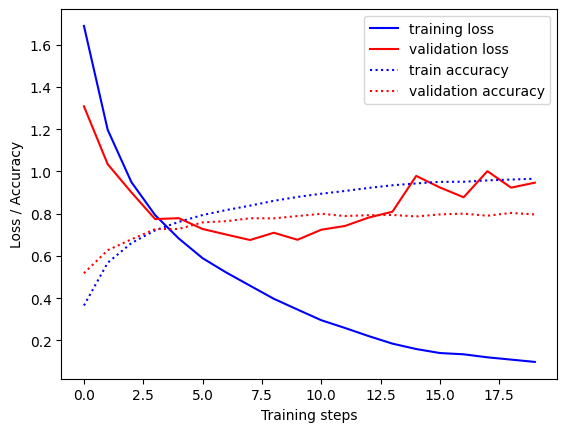

In [122]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)